<a href="https://colab.research.google.com/github/joaovictortbm/SummarizationHuggingFace/blob/main/T5summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U transformers
!pip install -U acelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install -U sentencepiece
!pip install -U urllib3
!pip install py7zr

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from datasets import load_dataset
dataset = load_dataset("cnn_dailymail", "3.0.0", split = "train[:10]")

In [3]:
dataset

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 10
})

In [4]:
print(dataset[0]['article'])
print("\nHighLights:\n ")
print(dataset[0]['highlights'])

LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. Details of how

# T5 and BART benchmarking

In [ ]:
from transformers import pipeline
summary = {}
t5_pipeline = pipeline("summarization", model = "ubikpt/t5-small-finetuned-cnn")
output = t5_pipeline(dataset[0]['article'])
summary['T5-small'] = output[0]['summary_text']

In [ ]:
bart_pipeline = pipeline("summarization", model = "facebook/bart-large-cnn")
output = bart_pipeline(dataset[0]['article'])
summary['Bart-large'] = output[0]['summary_text']

In [7]:
for model in summary:
  print('\n')
  print(f"Model: {model}")
  print(f"Summary: {summary[model]}")



Model: T5-small
Summary: Harry Potter star Daniel Radcliffe says he has no plans to fritter his cash away . The actor has filmed a TV movie about author Rudyard Kipling


Model: Bart-large
Summary: Harry Potter star Daniel Radcliffe turns 18 on Monday. He gains access to a reported £20 million ($41.1 million) fortune. Radcliffe's earnings from the first five Potter films have been held in a trust fund. Details of how he'll mark his landmark birthday are under wraps.


Using T5 model to save time

# Dataset Analysis

In [ ]:
samsum = load_dataset('knkarthick/samsum', trust_remote_code=True)

In [9]:
samsum

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
})

In [10]:
import pandas as pd

def clean_examples(example):
    dialogue = example.get('dialogue', None)
    summary = example.get('summary', None)

    if not isinstance(dialogue, str) or not isinstance(summary, str):
        return False

    if dialogue.strip() == "" or summary.strip() == "":
        return False

    example['dialogue'] = dialogue.strip()
    example['summary'] = summary.strip()

    return True

cleaned_dataset = samsum.filter(clean_examples)

Filter:   0%|          | 0/14732 [00:00<?, ? examples/s]

Filter:   0%|          | 0/818 [00:00<?, ? examples/s]

Filter:   0%|          | 0/819 [00:00<?, ? examples/s]

In [11]:
cleaned_dataset['train'][0]

{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\nJerry: Sure!\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}

In [12]:
dialogue_len = [len((x['dialogue'] or '').split()) for x in cleaned_dataset['train']]
summary_len = [len((x['summary'] or '').split()) for x in cleaned_dataset['train']]

array([[<Axes: title={'center': 'dialogue_len'}>,
        <Axes: title={'center': 'summary_len'}>]], dtype=object)

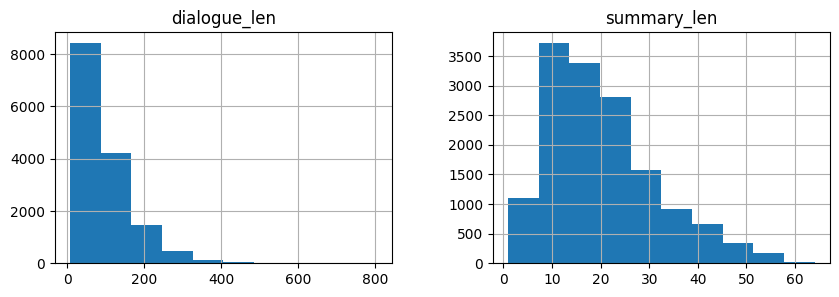

In [13]:
data = pd.DataFrame([dialogue_len, summary_len]).T
data.columns = ['dialogue_len', 'summary_len']
data.hist(figsize = (10,3))

# Tokenization

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
model_ckpt = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

In [15]:
model

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [16]:
tokenizer(cleaned_dataset['train'][0]['dialogue'], text_target = cleaned_dataset['train'][0]['summary'], return_tensors = 'pt')

{'input_ids': tensor([[21542,    10,    27, 13635,  5081,     5,   531,    25,   241,   128,
            58, 16637,    10, 10625,    55, 21542,    10,    27,    31,   195,
           830,    25,  5721,     3,    10,    18,    61,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'labels': tensor([[21542, 13635,  5081,    11,    56,   830, 16637,   128,  5721,     5,
             1]])}

In [17]:
def tokenize(batch):
  return tokenizer(batch['dialogue'], text_target = batch['summary'],
                   padding = True,
                   max_length=200,
                   truncation = True,
                   return_tensors = 'pt'
                   )

In [18]:
dataset_tokenized = cleaned_dataset.map(tokenize, batched = True)

Map:   0%|          | 0/14731 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

In [19]:
dataset_tokenized

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14731
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
})

# Model training

In [20]:
from transformers import DataCollatorForSeq2Seq, TrainingArguments, Trainer

data_collator = DataCollatorForSeq2Seq(tokenizer, model = model)
args = TrainingArguments(
    output_dir = "train_dir",
    num_train_epochs = 2,
    per_device_train_batch_size = 4,
    per_device_eval_batch_size = 8,
    weight_decay = 0.01,
    eval_strategy = 'epoch',
    save_strategy = 'epoch',
    learning_rate = 0.0005,
    gradient_accumulation_steps = 500,
)

In [ ]:
trainer = Trainer(
    model = model,
    args = args,
    data_collator = data_collator,
    train_dataset = dataset_tokenized['train'],
    eval_dataset = dataset_tokenized['validation']
)

trainer.train()

In [28]:
trainer.evaluate()

{'eval_loss': 0.9600744843482971,
 'eval_runtime': 8.1684,
 'eval_samples_per_second': 100.142,
 'eval_steps_per_second': 12.61,
 'epoch': 2.0}

# Testing model

In [32]:
trainer.save_model('t5_samsum_summarization')
tokenizer.save_pretrained('t5_samsum_summarization_tokenizer')

('t5_samsum_summarization_tokenizer/tokenizer_config.json',
 't5_samsum_summarization_tokenizer/special_tokens_map.json',
 't5_samsum_summarization_tokenizer/spiece.model',
 't5_samsum_summarization_tokenizer/added_tokens.json',
 't5_samsum_summarization_tokenizer/tokenizer.json')

In [33]:
from transformers import pipeline

summarizer = pipeline(
    "summarization",
    model="t5_samsum_summarization",
    tokenizer="t5_samsum_summarization_tokenizer",
    device=0
)

Device set to use cuda:0


In [39]:
text = """Emma: Did you watch the game last night?
Liam: Yeah, it was incredible!
Emma: I can't believe they won in the last minute.
Liam: Me neither, such a crazy ending!"""

summary = summarizer(text, max_length=100, min_length=10, do_sample=False)

print(f"\n{'Generated summary':^40}\n{'-'*40}\n{summary}\n{'-'*40}\n")

Your max_length is set to 100, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



           Generated summary            
----------------------------------------
[{'summary_text': 'julia brazilian won the game in the last minute . she was watching the game last night.'}]
----------------------------------------

